In [20]:
#import wandb
import numpy as np
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


In [21]:
import os
os.environ.get("LD_LIBRARY_PATH")

'/eos/home-g/gkrzmanc/miniforge3/lib:/home/gkrzmanc/env/lib:'

In [27]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/clustering_gt_with_pid_and_mean_features/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg"]
    h1_names = ["hit_eta_avg", "hit_phi_avg"]
    print("x shape:", r["x"].shape)
    xyz = r["node_features_avg"][:, [0,1,2]].cpu()
    eta_phi = torch.stack([calculate_eta(xyz[:, 0], xyz[:, 1], xyz[:, 2]), calculate_phi(xyz[:, 0], xyz[:, 1])], dim=1)
    return torch.concatenate([r["x"], xyz, eta_phi], dim=1), x_names + h_names + h1_names, r["true_e_corr"], r["e_true"], r["e_reco"], r["y_particles"][:, 6]


def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _, pids = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test = train_test_split(
        x, y, etrue, pids, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model

def calculate_phi(x, y):
    return np.arctan2(y, x)

def calculate_eta(x, y, z):
    theta = np.arctan2(np.sqrt(x**2 + y**2), z)
    return -np.log(np.tan(theta/2))

def main(ds, train_only_on_tracks=False, train_only_on_neutral=False, train_energy_regression=False):
    split = list(get_split(ds))
    gpus = [0]
    #wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        if train_only_on_tracks:
            mask = (split[0][:, 3] > 0) & (split[0][:, 7] == 1)
            split[0] = split[0][mask]
            split[2] = split[2][mask]
            split[4] = split[4][mask]
        elif train_only_on_neutral:
            mask = (split[0][:, 3] == 0) & (split[0][:, 7] == 0)
            split[0] = split[0][mask]
            split[2] = split[2][mask]
            split[4] = split[4][mask]
        if not train_energy_regression:
            result = model.fit(split[0], split[2])
            print("Fitted model:", result)
            # validation
            ypred = model.predict(split[1])
            ytrue = split[3]
            energies = split[5]
            return ytrue, ypred, energies, split[1], model, split
        else:
            result = model.fit(split[0], split[4])
            print("Fitted model:", result)
            # validation
            epred = model.predict(split[1])
            ytrue = split[3]
            ysum = split[1][:, 6]
            ypred = epred / ysum - 1
            energies = split[5]
            return ytrue, epred, energies, split[1], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError

def main_pandora():
    # just take the track p and energy of the hits for regression - so, "quasi-pandora"
    ds = get_dataset()
    print("Loaded dataset")
    split = get_split(ds)
    gpus = [0]
    #wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        result = model.fit(split[0][:, [3, 6]], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1][:, [3, 6]])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1][:, [3, 6]], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError



CUDA available: True


In [23]:
ds = get_dataset()
print("Loaded dataset")

x shape: torch.Size([123944, 8])
Loaded dataset


In [24]:
ds[0].shape

torch.Size([123944, 13])

In [25]:
neutral_yt, neutral_yp, neutral_en, _, neutral_model, neutral_split = main(ds=ds, train_only_on_neutral=True, train_energy_regression=True)

      Iter       Train Loss   Remaining Time 
         1         126.0840           20.56s
         2         103.0387           20.34s
         3          84.2933           19.53s
         4          69.1092           18.98s
         5          56.7524           18.61s
         6          46.7144           18.26s
         7          38.5453           18.02s
         8          31.9174           17.80s
         9          26.5286           17.56s
        10          22.1516           17.32s
        20           5.4655           15.20s
        30           3.1331           13.22s
        40           2.6686           11.34s
        50           2.5103            9.53s
        60           2.4288            7.63s
        70           2.3653            5.74s
        80           2.3156            3.82s
        90           2.2855            1.92s
       100           2.2530            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


In [26]:
yt_regression, yp_regression, en_regression, _, model_regression, split_regression = main(ds=ds, train_only_on_tracks=True, train_energy_regression=True)

      Iter       Train Loss   Remaining Time 
         1         128.5080           20.79s
         2         104.8470           20.19s
         3          85.6761           19.81s
         4          69.9768           19.41s
         5          57.3002           19.04s
         6          46.8946           18.85s
         7          38.4058           18.60s
         8          31.5487           18.50s
         9          25.9218           18.25s
        10          21.3808           17.98s
        20           3.7339           15.44s
        30           1.2406           13.37s
        40           0.7845           11.48s
        50           0.6526            9.54s
        60           0.5798            7.63s
        70           0.5335            5.71s
        80           0.5112            3.80s
        90           0.4883            1.90s
       100           0.4724            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


In [29]:
split_regression = list(get_split(ds))

In [ ]:
def plot(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(1+ytrue[mask], 1+ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("1+True E corr. fact.")
        ax[1].set_ylabel("1+Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        #wandb.log({"validation": wandb.Image(fig)})

plot(yt, yp, en)

In [ ]:
# ... Plotting with the energy of the sum of the hits...
plot(yt, yp, split[1][:, 6])

In [ ]:
def plot1(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            if i not in [0, 1, 2]:
                continue
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("True E corr. fact.")
        ax[1].set_ylabel("Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        #ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        #wandb.log({"validation": wandb.Image(fig)})
plot1(yt, yp, en)

In [16]:
import shap
import numpy as np
te = shap.TreeExplainer(model)
shap_vals = te.shap_values(np.array(split[1]))

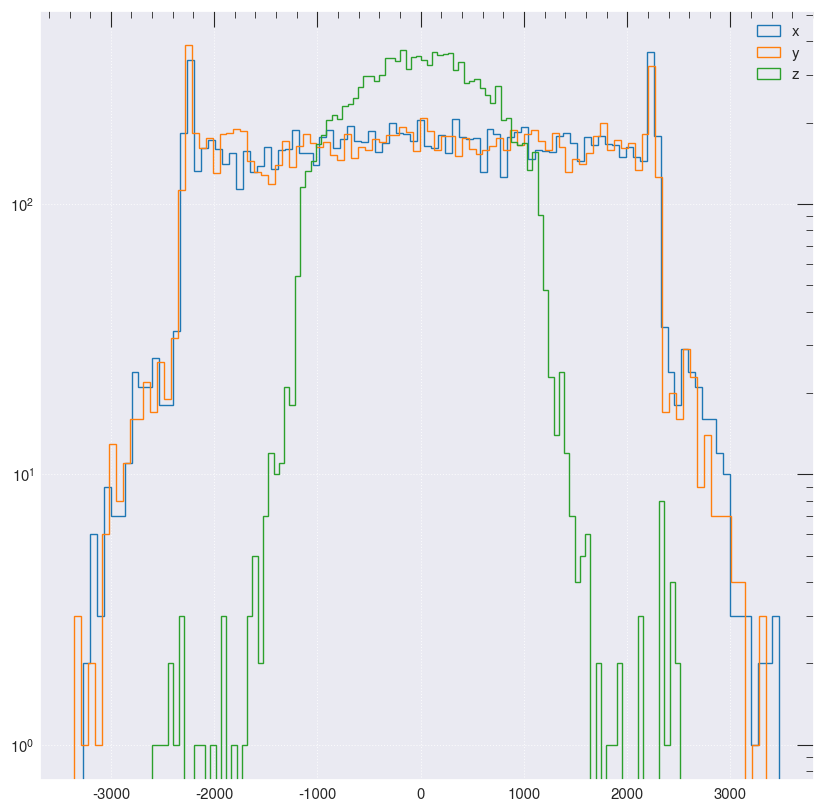

In [13]:
fig, ax = plt.subplots()
# hist of xyz
ax.hist(split_regression[1][:, 8], bins=100, histtype="step", label="x")
ax.hist(split_regression[1][:, 9], bins=100, histtype="step", label="y")
ax.hist(split_regression[1][:, 10], bins=100, histtype="step", label="z")
ax.set_yscale("log")
ax.legend()
fig.show()


In [ ]:
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
shap.summary_plot(shap_vals, split[1], feature_names=x_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks.pdf")

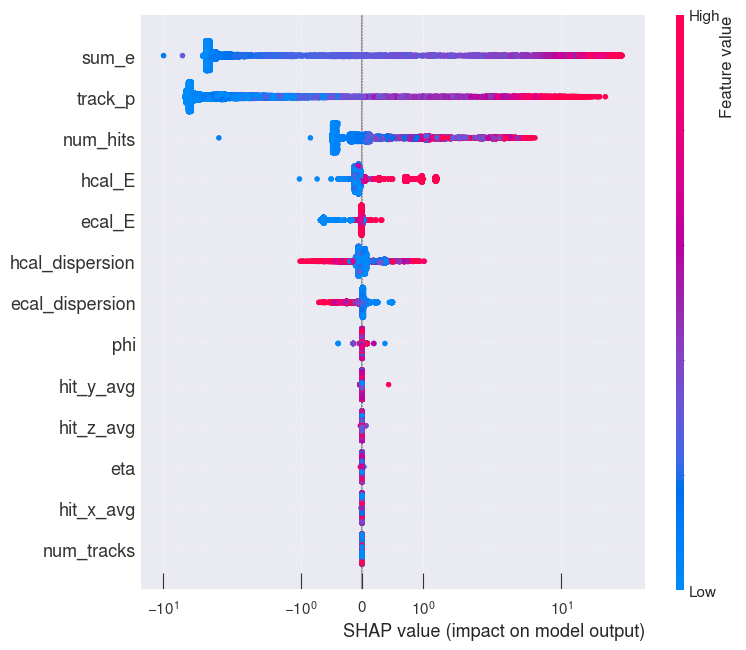

In [25]:
import shap
import numpy as np

te = shap.TreeExplainer(model_regression)
shap_vals_r = te.shap_values(np.array(split_regression[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
shap.summary_plot(shap_vals_r, split_regression[1], feature_names=x_names+h_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks_Regression_with_XYZ.pdf")

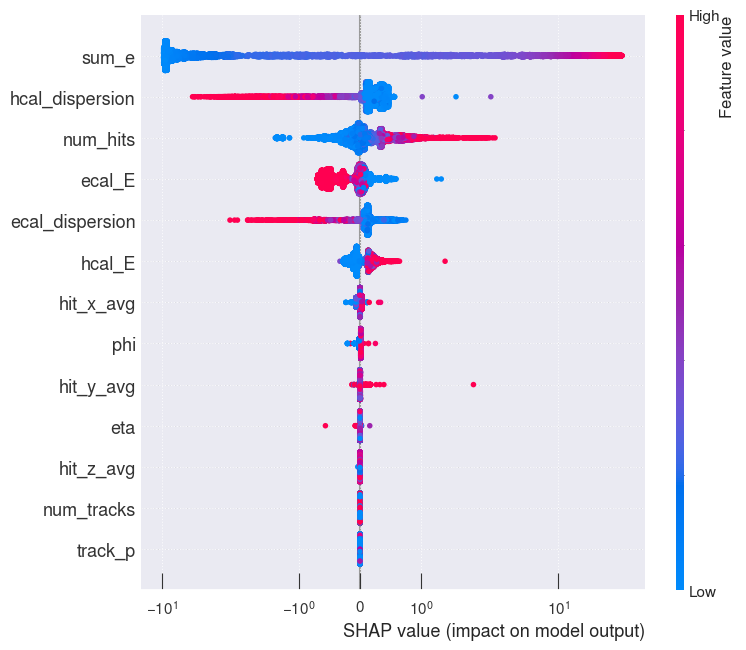

In [32]:
import shap
import numpy as np

te = shap.TreeExplainer(neutral_model)
shap_vals_r = te.shap_values(np.array(neutral_split[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
h_names = ["hit_x_avg", "hit_y_avg", "hit_z_avg", "eta", "phi"]
shap.summary_plot(shap_vals_r, neutral_split[1], feature_names=x_names+h_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_Neutrals_Regression_with_XYZ.pdf")


In [ ]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 6], 1+yt, label="True", alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

In [ ]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 3], 1+yt, alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

tensor(24214) 24214


NameError: name 'yt_pandora' is not defined

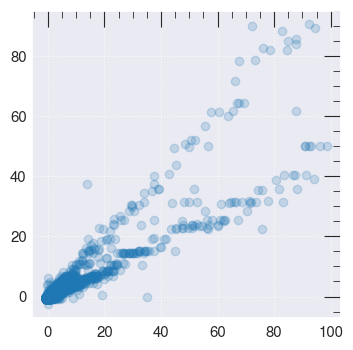

In [13]:
energies = split[1][:, 6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#mask = (energies > 0) & (energies < 1)
mask = (split[1][:, 3] > 0) & (split[1][:, 7] > 0)  # TRACKS
mask = energies > 0
print(mask.sum(), len(mask))
ax.scatter(yt[mask], yp[mask], label=f"All features", alpha=0.2)
ax.scatter(yt_pandora[mask], yp_pandora[mask], label=f"E+p", alpha=0.2)
# correlation coeff.
from scipy.stats import pearsonr
r, p = pearsonr(yt[mask], yp[mask])
r_pandora, p_pandora = pearsonr(yt_pandora[mask], yp_pandora[mask])
print("Correlation coeff. all features:", r, p)
print("Correlation coeff. E+p:", r_pandora, p_pandora)
ax.plot([0, 100], [0, 100], color="gray", linestyle="--")
ax.set_xlabel("True E corr. fact.")
ax.set_ylabel("Predicted E corr. fact.")
ax.legend()
fig.show()

In [ ]:
# define bins of the predicted corr. factor
bins = [-1, -0.75, -0.5, -0.25, -0.1, 0.1, 0.25, 0.5, 0.75, 1, 3, 5, 7, 10, 15, 30, 50, 100]
bins = [-1, -0.5, -0.1, 0.1, 0.5, 1, 5, 10, 50, 100]
n_plots = len(bins) - 1
corr_coeffs_ep, corr_coefs = [], []
bin_avg = []
fig, ax = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] > 0).clone().detach().cpu().numpy())
import numpy as np
for i in range(len(bins) - 1):
    mask = (yp > bins[i]) & (yp < bins[i + 1]) & (track_filter).detach().cpu().numpy()
    bin_avg.append(yp[mask].mean())
    ax[i].scatter(yt[mask], yp[mask], alpha=0.2, label="all feat.")
    ax[i].scatter(yt_pandora[mask], yp_pandora[mask], alpha=0.2, label="E+p")
    cc = round(pearsonr(yt[mask], yp[mask])[0], 2)
    cc_ep = round(pearsonr(yt_pandora[mask], yp_pandora[mask])[0], 2)
    corr_coeffs_ep.append(cc_ep)
    corr_coefs.append(cc)
    ax[i].set_title(f"{bins[i]}-{bins[i+1]} (cc = {cc} / {cc_ep})")
    #ax[i].plot([0, 100], [0, 100], color="gray", linestyle="--")
    ax[i].set_xlabel("True E corr. fact.")
    ax[i].set_ylabel("Predicted E corr. fact.")
    ax[i].legend()
fig.tight_layout()
#fig.savefig("/eos/user/g/gkrzmanc/2024/xgb_correction/energy_corr_vs_true_corr_regions.pdf")
fig.show()


In [ ]:

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(bin_avg, corr_coefs, ".--", label="All features")
ax.plot(bin_avg, corr_coeffs_ep, ".--", label="E+p")
ax.set_xlabel("Average predicted E corr. factor")
ax.set_ylabel("Correlation coefficient")
ax.legend()
fig.show()


In [31]:
import numpy as np
def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx
                    # ii = i
                    # jj = j

    return 0.5 * (high - low), low, high

def obtain_MPV_and_68(data_for_hist, bins_per_binned_E=np.arange(-1, 5, 0.01), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    return MPV, std68

In [12]:

# mpv, s68 = obtain_MPV_and_68(energies, bins_per_binned_E=np.arange(0, 2.5*energies.max().item(), 0.05))

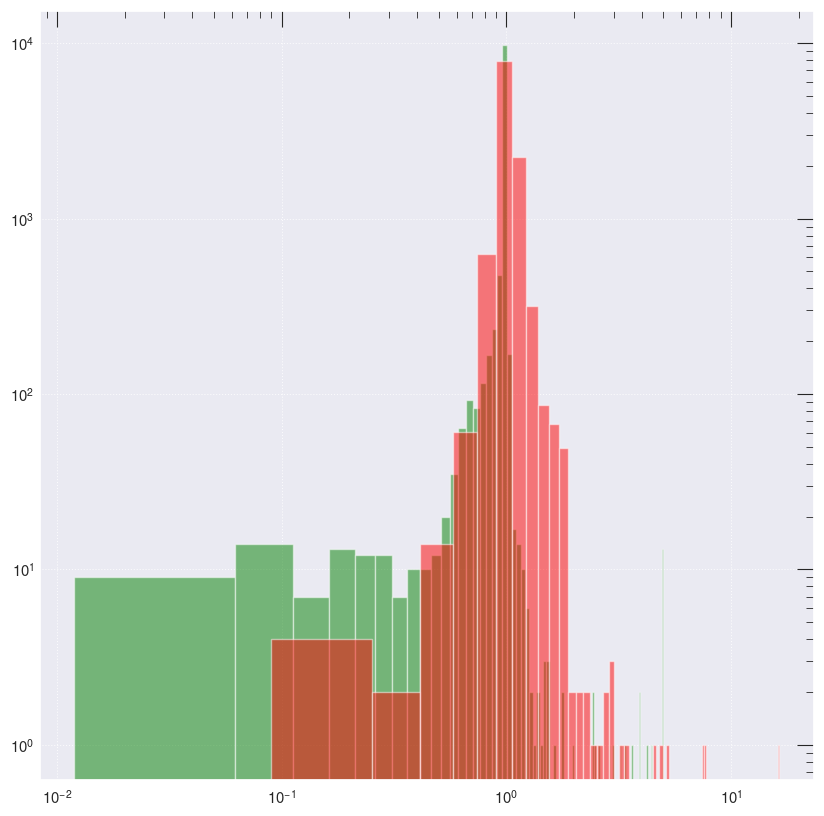

In [14]:
fig, ax = plt.subplots()
ax.hist(frac_track[track_filter].clip(max=5), bins=100, color="green", label="with track - Pandora", alpha=0.5)
ax.hist(frac_pred[track_filter], bins=100, color="red", label="with track", alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
fig.show()

/tmp/gkrzmanc/ipykernel_34921/3606510571.py:45: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[i-1].set_yscale("log")


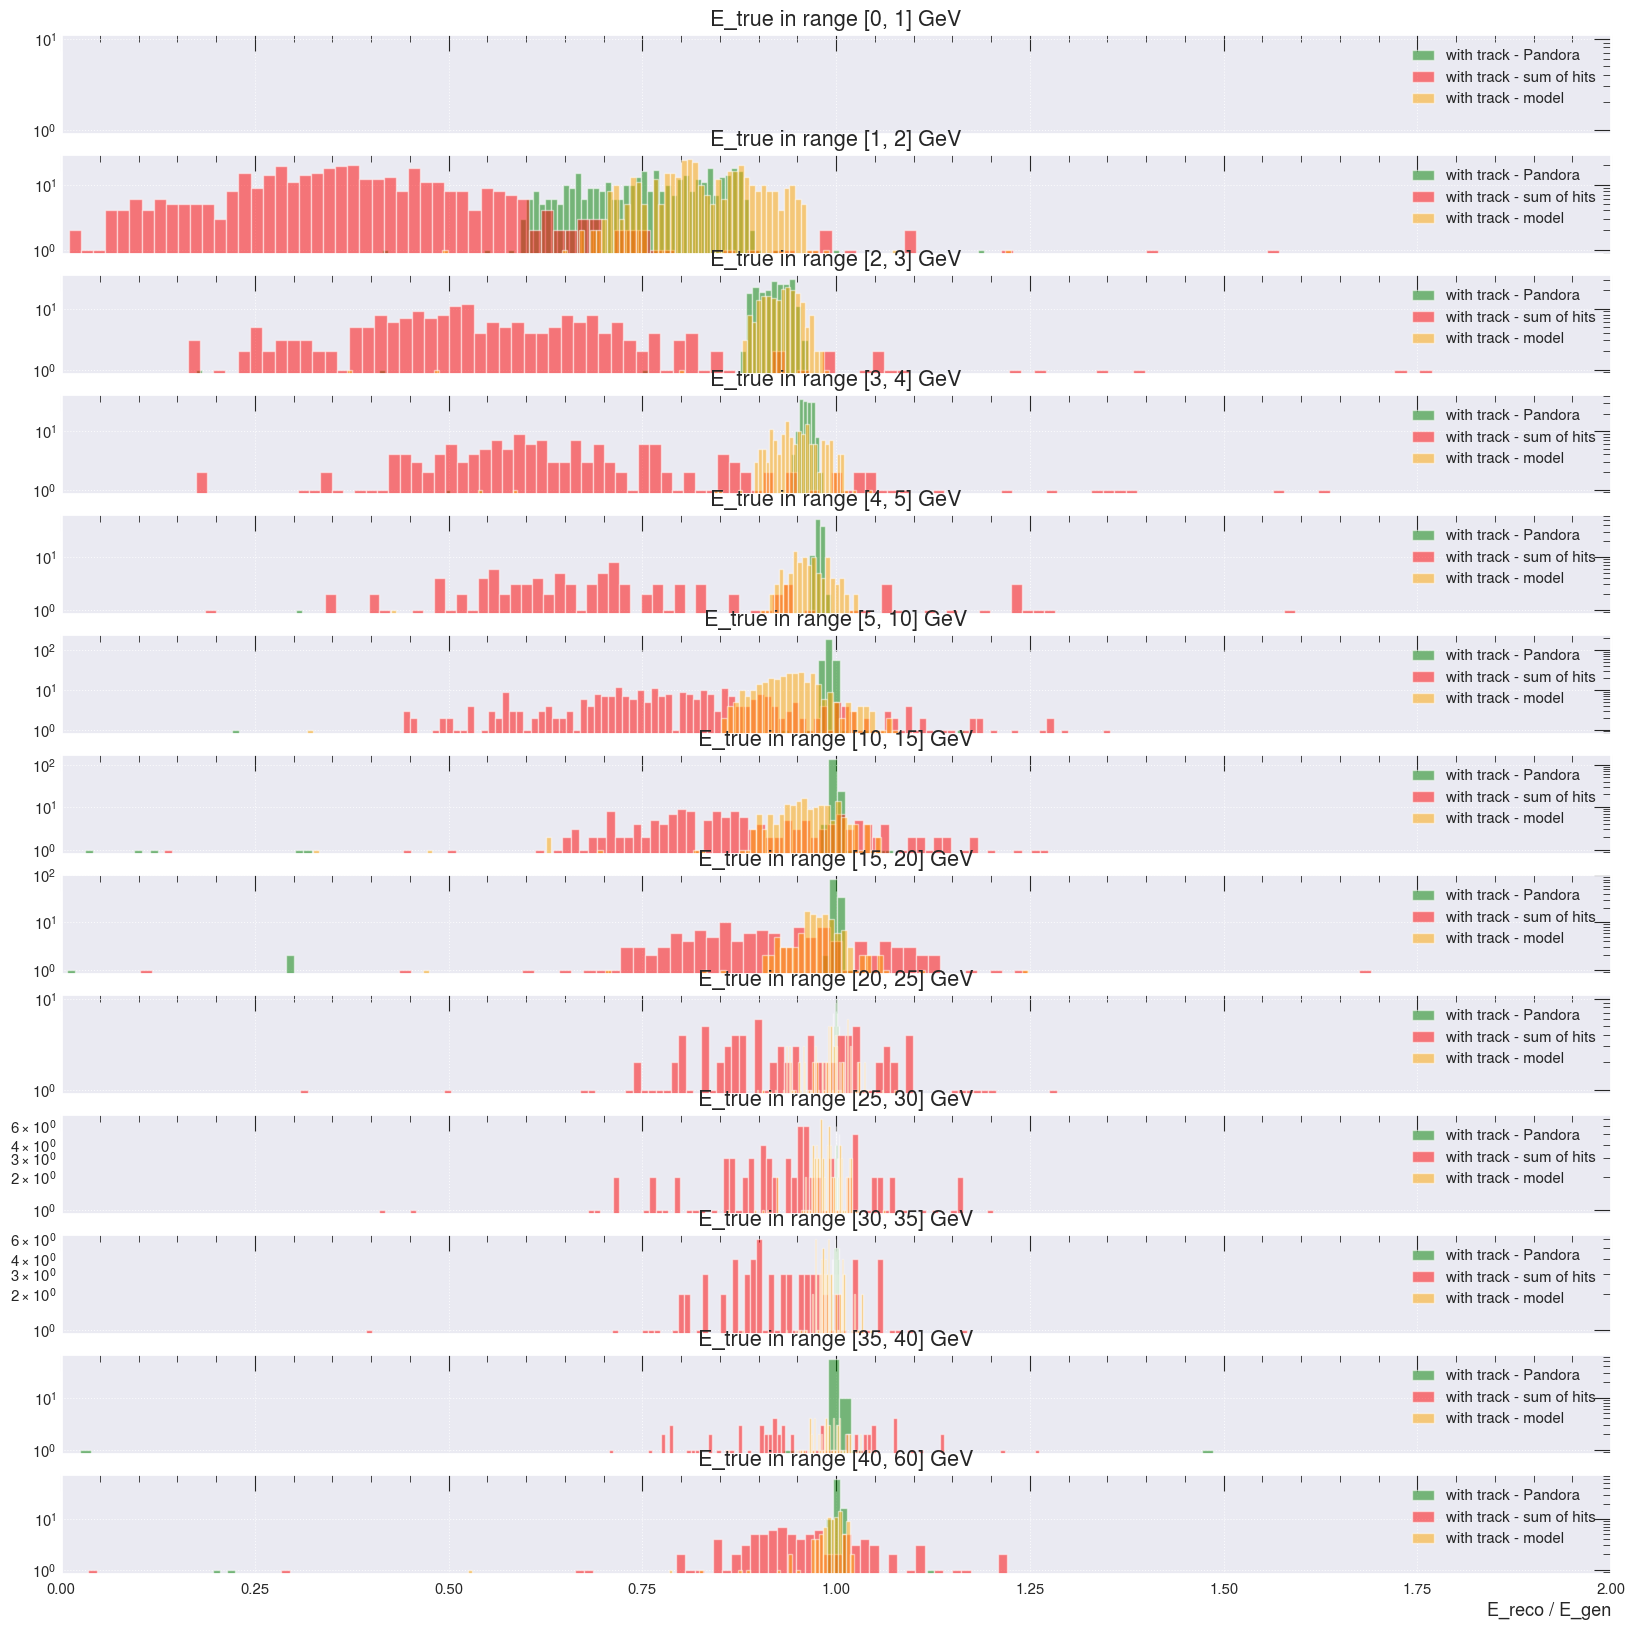

In [46]:
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor
e_thresholds = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 60]  # True E thresholds!
# set fig size

mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []
mpvs_sum_hits, s68s_sum_hits = [], []
mpvs_model_normalized, mpvs_pandora_normalized, mpvs_normalized_sum_hits = [], [], []

e_true = (1+yt_regression) * split_regression[1][:, 6].numpy()
e_pred = yp_regression
frac_pred = e_pred / e_true
frac_e_sum = split_regression[1][:, 6].clone().detach().cpu().numpy() / e_true
e_track = split_regression[1][:, 3].clone().detach().cpu().numpy()
frac_track = e_track / e_true
track_filter = ((split_regression[1][:, 3] > 0) & (split_regression[1][:, 7] == 1))
track_filter = track_filter & (split_regression[-1] == 2212).cpu()
#not_track_filter = ~track_filter
fig, ax = plt.subplots(len(e_thresholds) - 1, sharex=True, figsize=(20, 20))

binsize = 0.1 # ! TEMPORARILY !

for i, e_threshold in enumerate(e_thresholds):
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    ax[i-1].hist(frac_track.clip(max=5)[track_filter & filt_energy], bins=100, color="green", label="with track - Pandora", alpha=0.5)
    ax[i-1].hist(frac_e_sum[track_filter & filt_energy], bins=100, color="red", label="with track - sum of hits", alpha=0.5)
    ax[i-1].hist(frac_pred[track_filter & filt_energy], bins=100, color="orange", label="with track - model", alpha=0.5)
    mpv, s68 = obtain_MPV_and_68(e_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, _ = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_model_normalized.append(mpv)
    mpv, s68 = obtain_MPV_and_68(e_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    mpv, _ = obtain_MPV_and_68(frac_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_pandora_normalized.append(mpv)
    mpv, s68 = obtain_MPV_and_68(split_regression[1][:, 6].clone().detach().cpu().numpy()[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_sum_hits, s68s_sum_hits = mpvs_sum_hits + [mpv], s68s_sum_hits + [s68]
    mpv, _ = obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_normalized_sum_hits.append(mpv)
    ax[i-1].set_xlim([-1,3])
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV")
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
    ax[i-1].set_xlim([0, 2])
ax[-1].set_xlabel("E_reco / E_gen")
#fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/frac_hist_tracks_Regression_withexactly1track_2_with_XYZ.pdf"
fig.show()

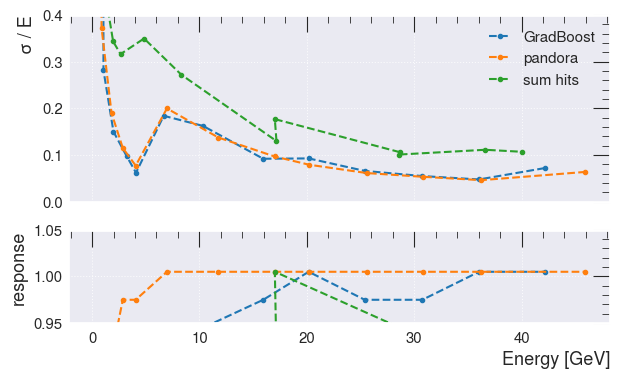

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots. 
ax[0].plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="GradBoost")
ax[0].plot(mpvs_pandora, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="pandora")
ax[0].plot(mpvs_sum_hits, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
ax[0].legend()
ax[1].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("σ / E")
ax[0].set_ylim([0, 0.4])
ax[1].plot(mpvs_model, mpvs_model_normalized, ".--", label="GradBoost")
ax[1].plot(mpvs_pandora, mpvs_pandora_normalized, ".--", label="pandora")
ax[1].plot(mpvs_sum_hits, mpvs_normalized_sum_hits, ".--", label="sum hits")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
#fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/response_and_resolution_tracks_Regression_1track_only_2_with_XYZ.pdf")
fig.show()

device(type='cpu')

In [ ]:
frac_pred[track_filter].max()

0
1
2
3
4
5
10
15
20
25
30
35
40
60


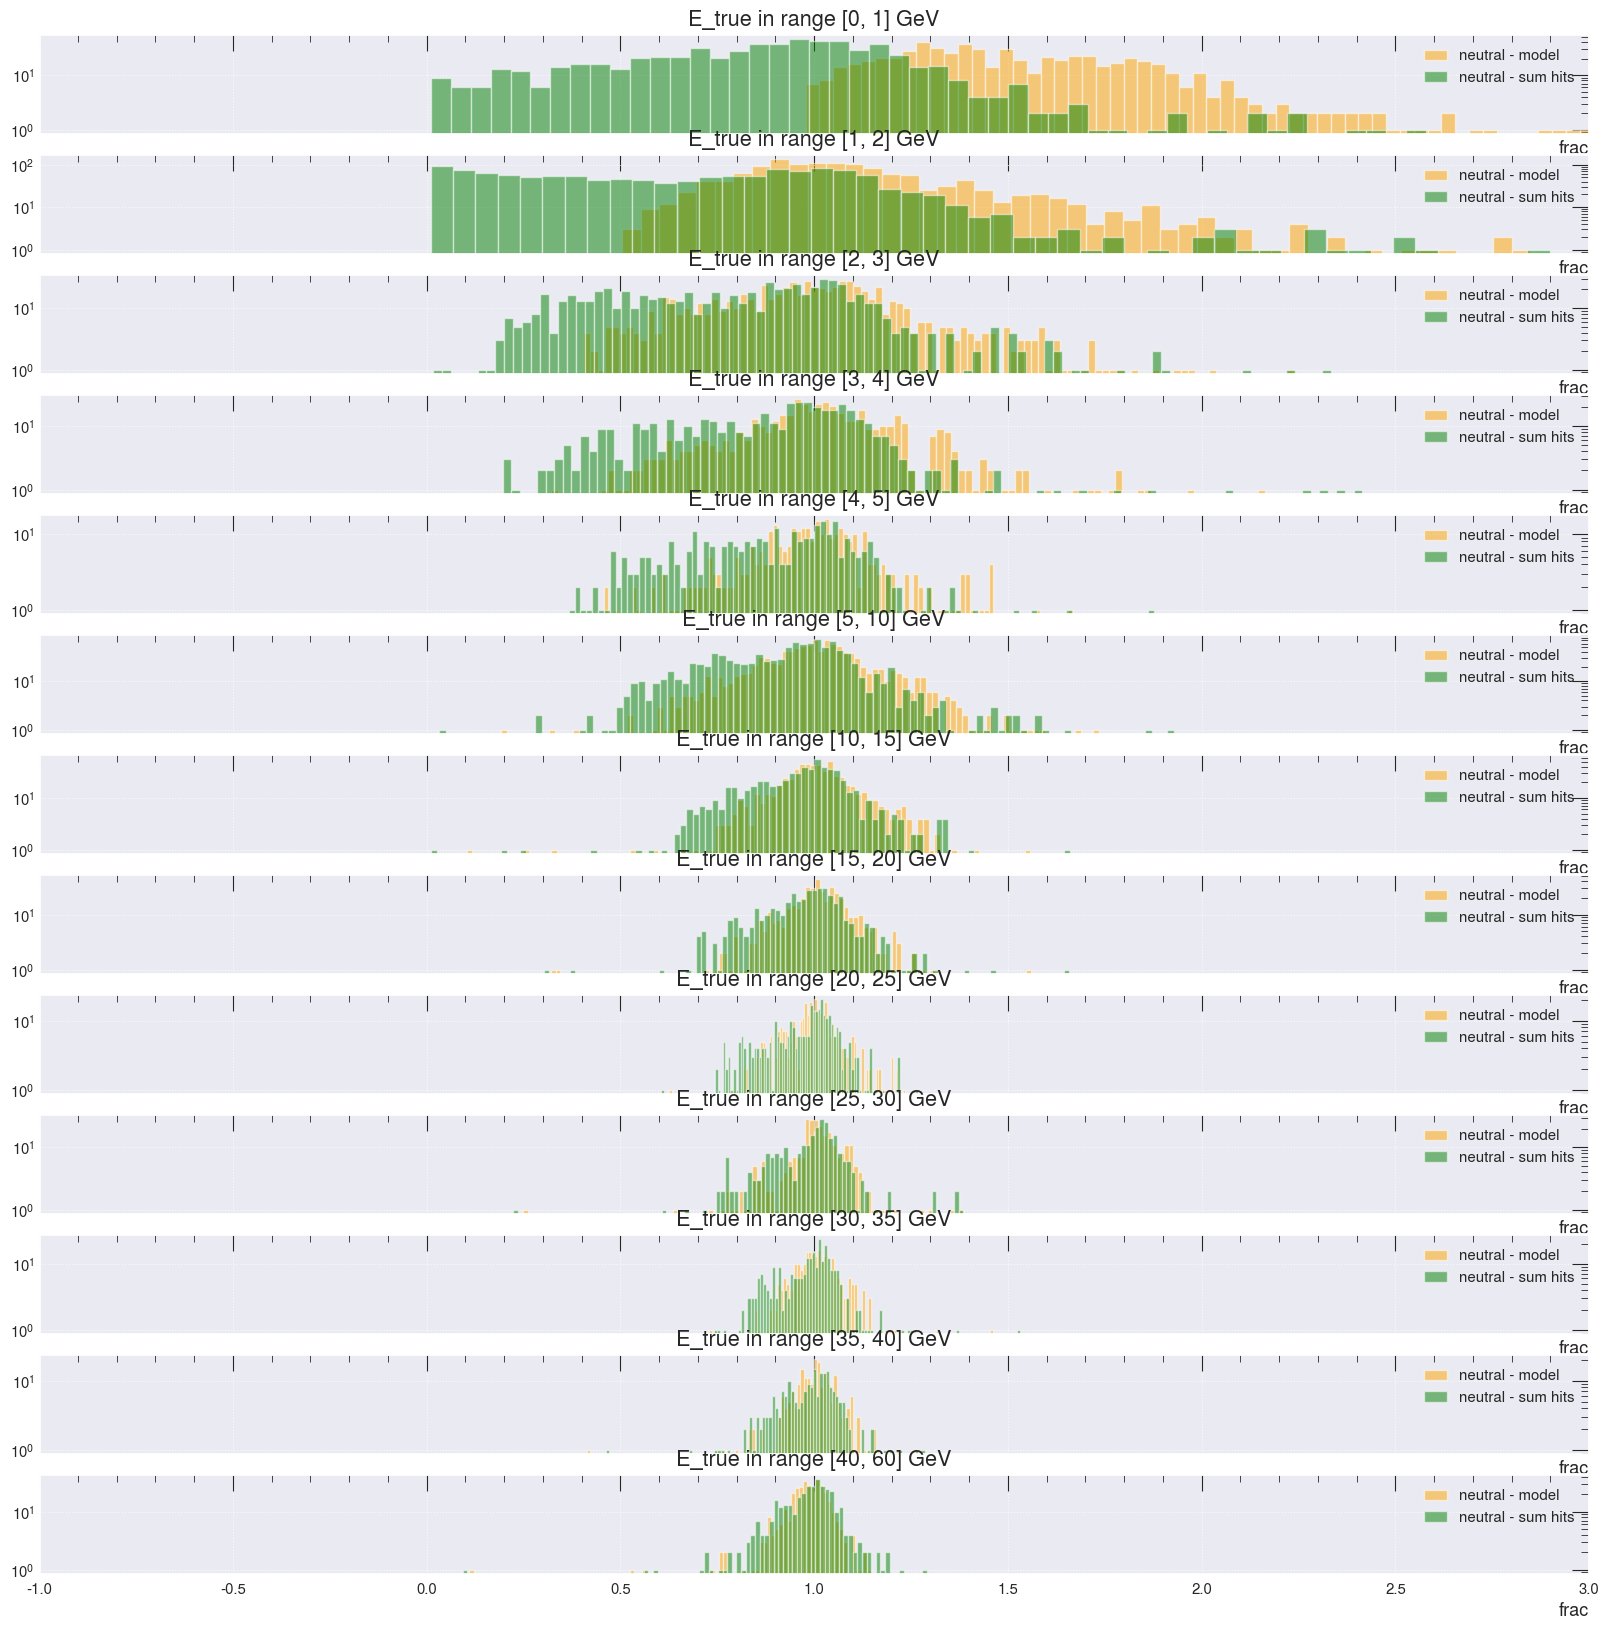

In [44]:
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor

e_thresholds = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 60]  # True E thresholds!

# set fig size
mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []
mpvs_normalized_model, mpvs_normalized_sumhits = [], []

e_true = (1+neutral_yt) * neutral_split[1][:, 6].numpy()
e_pred = neutral_yp  # Regression # # (1+neutral_yp) * neutral_split[1][:, 6].numpy()
frac_pred = e_pred / e_true
e_hits = neutral_split[1][:, 6].clone().detach().cpu().numpy()
frac_sum_hits = e_hits / e_true
not_track_filter = ((neutral_split[1][:, 3] == 0) & (neutral_split[1][:, 7] == 0))
eps = 0.02
fig, ax = plt.subplots(len(e_thresholds) - 1, figsize=(20, 20), sharex=True)
for i, e_threshold in enumerate(e_thresholds):
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    #print("sum", filt_energy.sum())
    ax[i-1].hist(frac_pred[not_track_filter & filt_energy], bins=100, color="orange", label="neutral - model", alpha=0.5)
    ax[i-1].hist(frac_sum_hits[not_track_filter & filt_energy], bins=100, color="green", label="neutral - sum hits", alpha=0.5)
    mpv, s68 = obtain_MPV_and_68(e_pred[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], eps))
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, _ = obtain_MPV_and_68(frac_pred[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5, eps))
    mpvs_normalized_model.append(mpv)
    mpv, s68 = obtain_MPV_and_68(e_hits[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], eps))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    mpv, _ = obtain_MPV_and_68(frac_sum_hits[not_track_filter & filt_energy], bins_per_binned_E=np.arange(0, 5, eps))
    mpvs_normalized_sumhits.append(mpv)
    # only hadronic
    ax[i-1].set_xlabel("frac")
    ax[i-1].set_xlim([-1,3])
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV")
    # log x axis
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
fig.savefig("/eos/home-g/gkrzmanc/2024/12_3_/frac_hist_neutral_regression2.pdf")

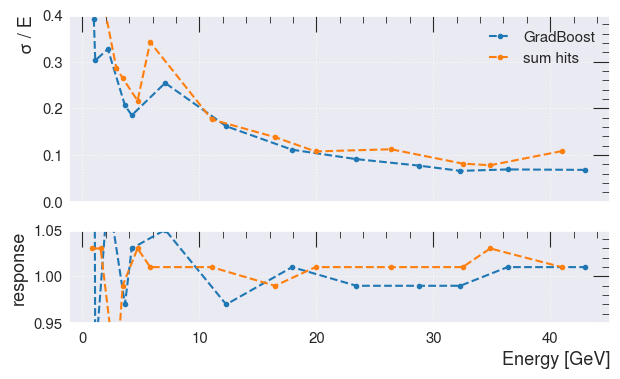

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots.
ax[0].plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="GradBoost")
ax[0].plot(mpvs_sum_hits, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
ax[0].legend()
ax[1].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("σ / E")
ax[0].set_ylim([0, 0.4])
ax[1].plot(mpvs_model, mpvs_normalized_model, ".--", label="GradBoost")
ax[1].plot(mpvs_sum_hits, mpvs_normalized_sumhits, ".--", label="sum hits")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/response_and_resolution_Neutral_Regression_1track_only_2_with_XYZ.pdf")

In [40]:
split_regression[-1].unique()

tensor([-2212.,  -211.,    11.,    22.,   130.,   211.,  2112.,  2212.],
       device='cuda:3')